In [1]:
library(igraph)
library(tidygraph)
library(tidyverse)
library(ggrepel)
library(cowplot)

theme_set(theme_cowplot())
results <- '../results/'


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘tidygraph’


The following object is masked from ‘package:igraph’:

    groups


The following object is masked from ‘package:stats’:

    filter


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ dplyr::filter()        masks tidygraph::filter(), stats::filter()
✖ dplyr::groups()        masks tidygraph::groups(), igraph::groups()
✖ dplyr::lag()           mask

In [2]:
vegas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), col_types = 'iciddddddcd') %>%
    select(Gene, `Top-0.1-pvalue`) %>%
    rename(name = Gene, p = `Top-0.1-pvalue`)
ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'),
                col_types = cols(.default = "c")) %>%
    select(`Official Symbol Interactor A`, `Official Symbol Interactor B`) %>%
    graph_from_data_frame(directed = FALSE) %>%
    as_tbl_graph
hgnc <- read_tsv(paste0(results,'preprocessing/non_alt_loci_set.txt'),
                 col_types = cols(.default = "c")) %>%
    select(symbol, ensembl_gene_id)
# wget ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_31/gencode.v31.annotation.gff3.gz
# gzcat gencode.v31.annotation.gff3.gz >gencode.v31.annotation.gff3
gene_types <- read_tsv(paste0(results,'bad_genes/gencode.v31.annotation.gff3'), comment = '#', 
                       col_names = FALSE, col_types = cols(.default = "c", X4 = 'd', X5 = 'd')) %>%
    filter(X3 == 'gene') %>%
    select(X9) %>%
    mutate(X9 = gsub('ID=', '', X9),
           X9 = gsub('\\.[0-9]+;gene_id.+gene_type=', ';', X9),
           X9 = gsub(';gene_name.+', '', X9)) %>%
    separate(X9, into = c('ensembl_gene_id','type'), sep = ';') %>%
    inner_join(hgnc, by = "ensembl_gene_id")

Warning message:
“Expected 2 pieces. Additional pieces discarded in 45 rows [60000, 60001, 60002, 60003, 60004, 60005, 60006, 60007, 60008, 60009, 60010, 60011, 60012, 60013, 60014, 60015, 60016, 60017, 60018, 60019, ...].”


# Total number of genes and PPIs

In [3]:
nrow(vegas)

[1] 32767

## HT

In [4]:
ppi

# A tbl_graph: 13619 nodes and 142541 edges
#
# An undirected multigraph with 15 components
#
# Node Data: 13,619 x 1 (active)
  name    
  <chr>   
1 HNRNPUL1
2 CDK16   
3 UBA1    
4 FAM107A 
5 TSNAX   
6 C15orf48
# … with 1.361e+04 more rows
#
# Edge Data: 142,541 x 2
   from    to
  <int> <int>
1     1  6313
2     2   647
3     2  2601
# … with 1.425e+05 more rows

In [5]:
filter(ppi, name %in% vegas$name)

# A tbl_graph: 12880 nodes and 127604 edges
#
# An undirected multigraph with 107 components
#
# Node Data: 12,880 x 1 (active)
  name    
  <chr>   
1 HNRNPUL1
2 FAM107A 
3 TSNAX   
4 C15orf48
5 TCL6    
6 SRSF2   
# … with 1.287e+04 more rows
#
# Edge Data: 127,604 x 2
   from    to
  <int> <int>
1     1  5956
2     2   954
3     2  2054
# … with 1.276e+05 more rows

## HT + LC

In [6]:
ppi_lc <- read_tsv(paste0(results,'lc_ht_network/hint.hgnc.pseudo.tab2'),
                col_types = cols(.default = "c")) %>%
    select(`Official Symbol Interactor A`, `Official Symbol Interactor B`) %>%
    graph_from_data_frame(directed = FALSE) %>%
    as_tbl_graph
ppi_lc

# A tbl_graph: 14512 nodes and 173796 edges
#
# An undirected multigraph with 248 components
#
# Node Data: 14,512 x 1 (active)
  name    
  <chr>   
1 HNRNPUL1
2 CDK16   
3 UBA1    
4 FAM107A 
5 TSNAX   
6 C15orf48
# … with 1.451e+04 more rows
#
# Edge Data: 173,796 x 2
   from    to
  <int> <int>
1     1  8229
2     2   786
3     2  3333
# … with 1.738e+05 more rows

In [7]:
filter(ppi_lc, name %in% vegas$name)

# A tbl_graph: 13735 nodes and 156190 edges
#
# An undirected multigraph with 325 components
#
# Node Data: 13,735 x 1 (active)
  name    
  <chr>   
1 HNRNPUL1
2 FAM107A 
3 TSNAX   
4 C15orf48
5 TCL6    
6 SRSF2   
# … with 1.373e+04 more rows
#
# Edge Data: 156,190 x 2
   from    to
  <int> <int>
1     1  7779
2     2  1179
3     2  2615
# … with 1.562e+05 more rows

# Mapping matches

Warning message:
“Removed 33041 rows containing missing values (geom_label_repel).”


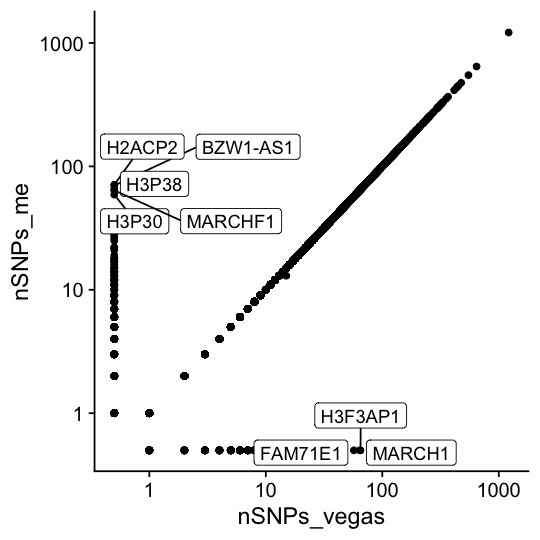

In [8]:
n_snps_vegas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), 
                         col_types = 'iciddddddcd') %>%
    select(Gene, nSNPs)
n_snps_me <- read_tsv(paste0(results,'preprocessing/snp2hgnc.tsv'), col_types = 'cc') %>%
    group_by(gene) %>%
    summarize(nSNPs = n())

options(repr.plot.width=4.5, repr.plot.height=4.5)
n_snps_diff <- full_join(n_snps_vegas, n_snps_me,
          by = c('Gene' = 'gene'), suffix = c('_vegas', '_me')) %>%
    mutate(nSNPs_vegas = ifelse(is.na(nSNPs_vegas), .5, nSNPs_vegas),
           nSNPs_me = ifelse(is.na(nSNPs_me), .5, nSNPs_me),
           diff = nSNPs_vegas - nSNPs_me,
           lab = ifelse(abs(diff) > 50, Gene, NA))

n_snps_diff %>%
    ggplot(aes(x = nSNPs_vegas, y = nSNPs_me, label = lab)) +
        geom_point() +
        geom_label_repel() +
        scale_x_log10() +
        scale_y_log10()

In [9]:
mean(n_snps_diff$diff[n_snps_diff$diff != 0])
sum(n_snps_diff$diff != 0) / sum(n_snps_diff$diff == 0)

[1] -1.120293

[1] 0.01467563

# Unmapped genes/SNPs

In [10]:
degree_p <- ppi %>%
    mutate(degree = centrality_degree()) %>%
    as_tibble %>%
    full_join(vegas, by = 'name') %>%
    mutate(degree = ifelse(is.na(degree), 1e-1, degree),
           p = ifelse(is.na(p), 10, p))

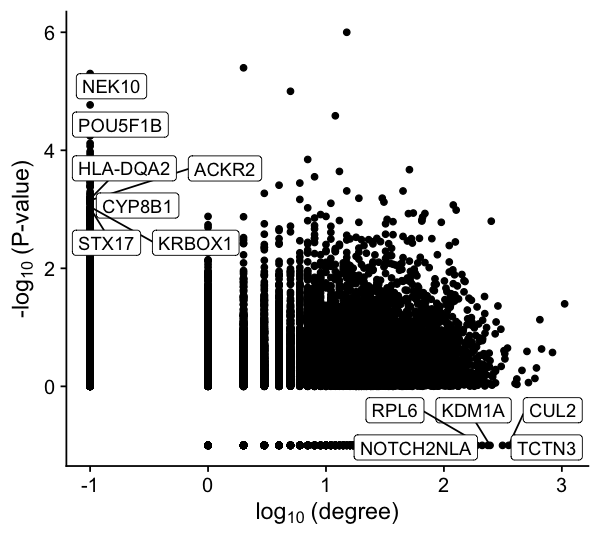

In [11]:
is_protein_coding <- degree_p$name %in% gene_types$symbol[gene_types$type == 'protein_coding']

set.seed(42)

options(repr.plot.width=5, repr.plot.height=4.5)
ggplot(degree_p, aes(x = log10(degree), y = -log10(p))) +
    geom_point() +
    geom_label_repel(data = filter(degree_p, p < 10e-4 & degree == 0.1 & is_protein_coding), 
                     aes(x = log10(degree), y = -log10(p), label = name)) +
    geom_label_repel(data = filter(degree_p, p == 10 & degree > 200), 
                     aes(x = log10(degree), y = -log10(p), label = name)) +
    labs(x = bquote('log' [10] ~'(degree)'),
         y = bquote('-log' [10] ~'(P-value)'))

# Genes in the network with no mapped SNPs

In [12]:
genes_icogs <- vegas$name %>% unique
genes_hint <- as_tibble(ppi)$name

# genes with no p-value
setdiff(genes_hint, genes_icogs) %>% length
# genes in the network
length(genes_hint)

[1] 739

[1] 13619

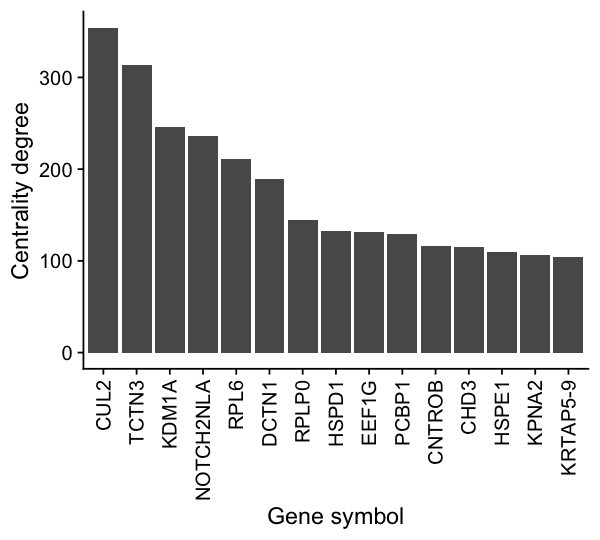

In [13]:
filter(degree_p, ! name %in% genes_icogs) %>%
    arrange(-degree) %>%
    mutate(name = factor(name, levels = name)) %>%
    head(15) %>%
    ggplot(aes(x = name, y = degree)) +
        geom_bar(stat = 'identity') +
        labs(x = 'Gene symbol', y = 'Centrality degree') +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))

## Comparison to other chips

TODO

## Comparison to iCOGS pre-QC

In [14]:
pre_qc <- read_tsv(paste0(results,'bad_genes/snp2gene.preqc.tsv'), col_types = 'cc')
genes_pre_qc <- pre_qc$gene %>% unique

# number of genes lost in qc
setdiff(genes_pre_qc, genes_icogs) %>% length

[1] 380

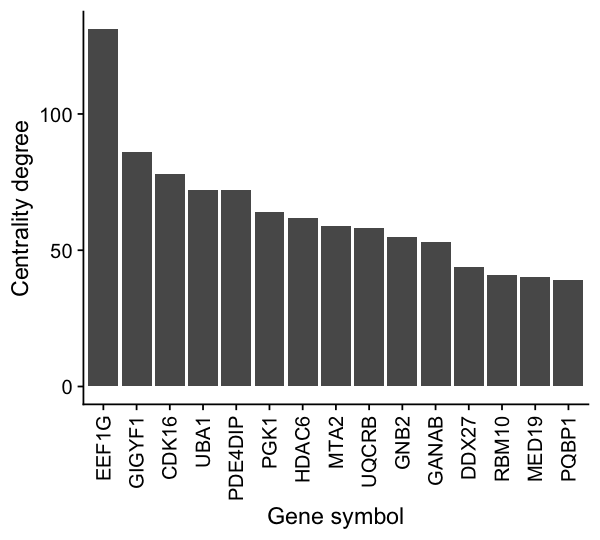

In [15]:
filter(degree_p, name %in% setdiff(genes_pre_qc, genes_icogs)) %>%
    arrange(-degree) %>%
    mutate(name = factor(name, levels = name)) %>%
    head(15) %>%
    ggplot(aes(x = name, y = degree)) +
        geom_bar(stat = 'identity') +
        labs(x = 'Gene symbol', y = 'Centrality degree') +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))

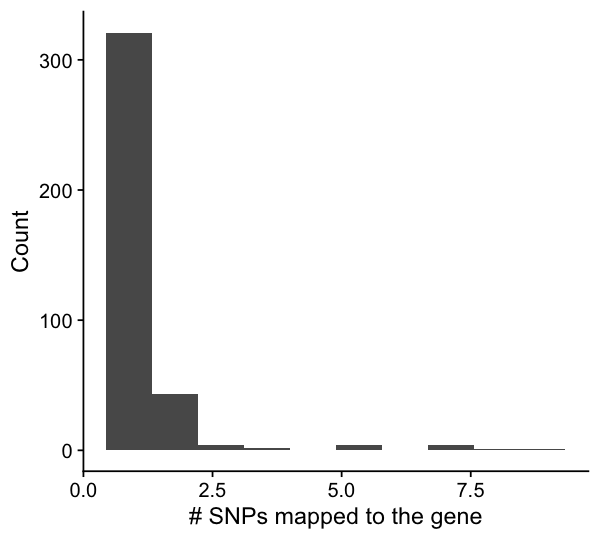

In [16]:
filter(pre_qc, gene %in% setdiff(genes_pre_qc, genes_icogs)) %>%
    group_by(gene) %>%
    summarize(n = n()) %>%
    ggplot(aes(x = n)) +
        geom_histogram(bins = 10) +
        labs(x = '# SNPs mapped to the gene', y = 'Count')

# Genes with no interactions

In [17]:
# genes with no ppi
setdiff(genes_icogs, genes_hint) %>% length
# genes icogs
length(genes_icogs)

[1] 19887

[1] 32767

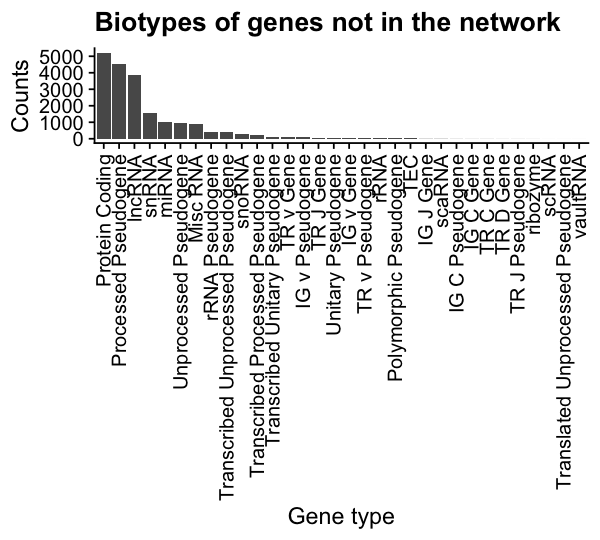

In [18]:
filter(gene_types, symbol %in% setdiff(genes_icogs, genes_hint)) %>%
    mutate(type = gsub('_', ' ', type),
           type = ifelse(grepl(' ', type), tools::toTitleCase(type), type)) %>%
    group_by(type) %>%
    summarize(n = n()) %>%
    arrange(-n) %>%
    ungroup %>%
    mutate(type = factor(type, levels = type)) %>%
    ggplot(aes(x = type, y = n)) +
        geom_bar(stat = 'identity') +
        labs(x = 'Gene type', y = 'Counts', title = 'Biotypes of genes not in the network') +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))

In [19]:
filter(degree_p, degree == 0.1 & is_protein_coding) %>% nrow

[1] 5227

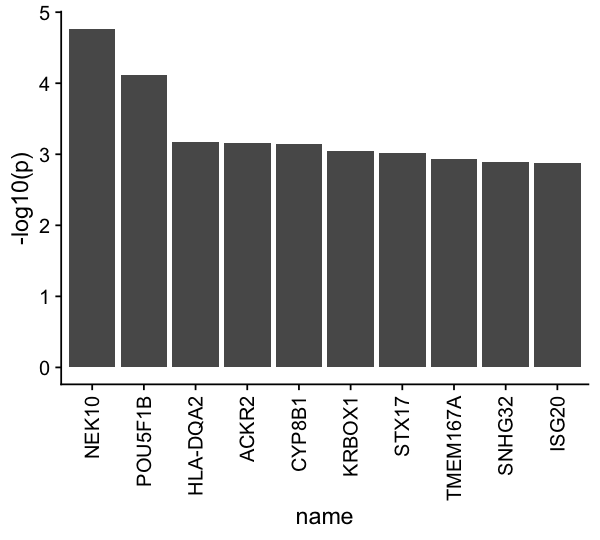

In [20]:
filter(degree_p, degree == 0.1 & is_protein_coding) %>%
    arrange(p) %>%
    mutate(name = factor(name, levels = unique(name))) %>%
    head(10) %>%
    ggplot(aes(name, -log10(p))) +
        geom_bar(stat = 'identity') +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))

In [21]:
median(degree_p$p[is_protein_coding & degree_p$degree != 0.1])
median(degree_p$p[is_protein_coding & degree_p$degree == 0.1])

# compare distribution of p-values
wilcox.test(degree_p$p[is_protein_coding & degree_p$degree != 0.1],
            degree_p$p[is_protein_coding & degree_p$degree == 0.1])

[1] 0.4825175

[1] 0.4685315


	Wilcoxon rank sum test with continuity correction

data:  degree_p$p[is_protein_coding & degree_p$degree != 0.1] and degree_p$p[is_protein_coding & degree_p$degree == 0.1]
W = 37127946, p-value = 3.706e-08
alternative hypothesis: true location shift is not equal to 0


# Rarities

In [22]:
# genes that vegas maps and I do not
filter(degree_p, degree == 0.1) %>%
    filter(! name %in% genes_icogs) %>%
    arrange(p)

name,degree,p
<chr>,<dbl>,<dbl>
